# Missing Values

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from fancyimpute import KNN, SimpleFill
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# from sklearn.calibration import calibration_curve
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# from sklearn.naive_bayes import BernoulliNB
plt.style.use('ggplot')

- look at a statistic for amount of variance reduced after imputation 
- is SVM good comparison algorithm?
- Draw actual DB of data and DB of imputed data
    - With smaller variance should have different DB shape

### Generating Data


In [8]:
n=1000
np.random.seed(1)

X,Y = datasets.make_classification(n_samples = n,
                                   n_features=2,
                                   n_redundant=0,
                                   n_informative=2,
                                   n_clusters_per_class=1,
                                   class_sep=2,
                                   random_state=3)

In [9]:
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.25, random_state= 42)
X, X_test, Y, Y_test = pd.DataFrame(X), pd.DataFrame(X_test), pd.DataFrame(Y), pd.DataFrame(Y_test)



"""
arg: X is df of values
     p is prop of missing data
return: X with that prop of data missing
"""
def insertMissing(df, prop = 0.2):
    df = df.copy()
    numObs, numPred = df.shape
    for predI in range(numPred):
        missingArray = np.random.binomial(size = numObs, n = 1, p = 1-prop)
        for obsI in range(numObs):
            if not missingArray[obsI]:
                df[predI][obsI] = np.nan
    return df
    
Xmissing = insertMissing(X, 0.2)
Ymissing = insertMissing(Y, 0.2)

## Imputation

- Classes
    - Proportional
    - KNN voting
- For Features:
    - KNN 
    - Mean 
- For a given class, no values for a feature
    - LaPlace smoothing

In [10]:
# Find proportion of class 0 of Y
def classProp(df):
    sum0 = (df[0] == 0).sum()
    sum1 = (df[0] == 1).sum()
    return sum0/(sum0+sum1)

# Impute classes for binary Y by proportion of that class
def classImpute(df):
    tempDF = df.copy()
    prop0 = classProp(tempDF)
    for i in range(len(df[0])):
        if np.isnan(tempDF[0][i]):
            if random.random() > prop0:
                tempDF[0][i]= 1
            else:
                tempDF[0][i]=0
    return tempDF

In [11]:
XmeanImpute = pd.DataFrame(SimpleFill().fit_transform(Xmissing))
YpropImpute = classImpute(Ymissing)

In [12]:
%%capture
## Capture output from KNN imputation

#KNN imputation does its best then fills in with 0 otherwise
##Here only 6 values in each column are assigned 0
XknnImpute = pd.DataFrame(KNN(k=5).fit_transform(Xmissing))

In [13]:
print("XmissingSTD: %s,\n XmeanSTD: %s\n, XknnSTD: %s" % (Xmissing.std(), XmeanImpute.std(), XknnImpute.std()))

XmissingSTD: 0    0.501329
1    2.065021
dtype: float64,
 XmeanSTD: 0    0.446828
1    1.838979
dtype: float64
, XknnSTD: 0    0.626637
1    1.931749
dtype: float64


## Naive Bayes performance

In [14]:
gnb = GaussianNB()

##TODO pass test set to function also
## right now X and Y are pandas df's
def getAccuracy(X, Y, xtest, ytest, method=gnb):
    pred = method.fit(X, Y[0]).predict(xtest)
    correct = (pred==list(ytest[0])).sum()
    return float(correct)/ytest.shape[0]

full_acc = getAccuracy(X, Y, X_test, Y_test)

print("Test Accuracy with no Missing: %s" % (full_acc))

Test Accuracy with no Missing: 0.996


### X with missing data imputed

In [15]:
XmeanImpute.shape

meanImpute_acc = getAccuracy(XmeanImpute, Y, X_test, Y_test)
print("Accuracy on X mean impute: %s \n" % (meanImpute_acc))

knnImpute_acc = getAccuracy(XknnImpute, Y, X_test, Y_test)
print("Accuracy on X knn impute: %s" % (knnImpute_acc))

Accuracy on X mean impute: 0.996 

Accuracy on X knn impute: 0.996


   #### Getting a range of imputed data for X

In [16]:
def makeMissingList(X, Y, props):
    X_missing_list = list()
    
    for i in props:
        newMissX = insertMissing(X, i)
        X_missing_list.append(newMissX)
    
    return X_missing_list

def getMissingAccuracies(X, Y, props, impute = 'mean', method=gnb):
    imputeFunction = SimpleFill().fit_transform if impute == 'mean' else KNN(k=10).fit_transform
    X_missing_list = makeMissingList(X, Y, props)
    
    missing_acc = list()
    for x in X_missing_list:
        x_imputed = pd.DataFrame(imputeFunction(x))
        ### TODO should have X_test and Y_test as parameters
        acc = getAccuracy(x_imputed, Y, X_test, Y_test, method)
        missing_acc.append(acc)
    
    ### concat accuracy list and np.arange
    acc_df = pd.concat([pd.Series(props), pd.Series(missing_acc)], axis=1)
    return acc_df

#### Logistic Regression

In [17]:
x_miss_list = makeMissingList(X, Y, np.arange(0,1,0.02))
lr = LogisticRegression(solver="lbfgs")

lrFullModel = lr.fit(X, Y[0])
lrFullPred = lrFullModel.predict(X_test)

lrFullAcc = np.sum(lrFullPred == Y_test[0])/len(Y_test)
print("Log Reg acc on test X, no missing: ", lrFullAcc)

Log Reg acc on test X, no missing:  0.996


#### SVM

In [18]:
svm = LinearSVC()
svmFullModel = svm.fit(X, Y[0])
svmFullPred = svmFullModel.predict(X_test)

svmFullAcc = np.sum(svmFullPred==Y_test[0])/len(Y_test)
print("SVM acc on full X, no missing: ", svmFullAcc)

SVM acc on full X, no missing:  0.996


### Plot of Accuracy vs Prop of Missing Data Imputed 
##### Mean Impute

In [28]:
missingRange = np.arange(0.3,1, ((1-.3)/50))

In [29]:
%%capture
acc_mean_gnb = getMissingAccuracies(X, Y, missingRange)
acc_mean_lr = getMissingAccuracies(X, Y, missingRange, method=lr)
acc_mean_svm = getMissingAccuracies(X, Y, missingRange, method=svm)

Text(0.5, 1.0, 'Accuracy on Mean imputed')

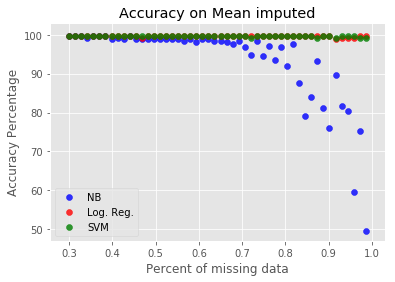

In [31]:
plt.scatter(x=missingRange, y=(acc_mean_gnb[1]*100), c="blue", label="NB", alpha=0.8)
plt.scatter(x=missingRange, y=(acc_mean_lr[1]*100), c='red', label="Log. Reg.", alpha=0.8)
plt.scatter(x=missingRange, y=(acc_mean_svm[1]*100), c='green', label="SVM", alpha=0.8)
plt.legend()
plt.xlabel("Percent of missing data")
plt.ylabel("Accuracy Percentage")
plt.title("Accuracy on Mean imputed")

##### KNN Impute (K=10)

In [32]:
%%capture

acc_knn_gnb = getMissingAccuracies(X, Y, missingRange, impute="KNN")
acc_knn_lr = getMissingAccuracies(X, Y, missingRange, impute="KNN", method = lr)
acc_knn_svm = getMissingAccuracies(X, Y, missingRange, impute="KNN", method = svm)

Text(0.5, 1.0, 'Accuracy on KNN imputed')

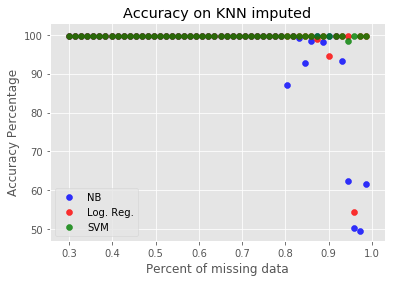

In [33]:
plt.scatter(x=missingRange, y=(acc_knn_gnb[1]*100), c="blue", label="NB", alpha=0.8)
plt.scatter(x=missingRange, y=(acc_knn_lr[1]*100), c='red', label="Log. Reg.", alpha=0.8)
plt.scatter(x=missingRange, y=(acc_knn_svm[1]*100), c='green', label="SVM", alpha=0.8)
plt.legend()
plt.xlabel("Percent of missing data")
plt.ylabel("Accuracy Percentage")
plt.title("Accuracy on KNN imputed")

## Y with missing data imputed

In [64]:
yPropImpute_acc = getTrainAccuracy(X, YpropImpute)
print("Accuracy with proportional Y imputed:  %s" % (yPropImpute_acc))

Accuracy with proportional Y imputed:  0.936


## Conclusions

**Variance**
- changes when impute (especially mean impute)
    - where will it misclassify new points?
- class impute effect?

